## Intro to Machine Learning and Deep learning
---
The goal of this assignment is to familiarize with the linear regression methods:

1. [:white_check_mark:] Repeat the previous jupyter notebook using the diabetes database
   ```python
   ...
   import mean_squared_error, r2_score
   # load the diabetes dataset
   diabetes_X, diabetes_Y = datasets.load(return_X_y=True)
   ```
2. [:white_check_mark:] Find labels and use them to build a linear classifier:
   - [:white_check_mark:] Use a threshold to decide what are the labels in the data.
   - [:white_check_mark:] Generate the $\bm{\tilde{X}}$ augmented samples and the $\bm{Y}$ labels and build the classifier.   
3. [:white_check_mark:] Then use the following $\verb+linear_model+$ package from $\verb+sklearn+$:
    ```python
    from sklearn import linear_model
    ```
4. [:white_check_mark:] Fit the X and Y using the instruction:
   ```python
   # Create a linear regression
   object regr = linear_model.LinearRegression()
   # Train the model using the training sets
   regr.fit(diabetes_X_train, diabetes_Y_train)
   # Make predictions using the testing
   set diabetes_Y_pred = regr.predict(diabetes_X_test)
   ```
5. [:hourglass_flowing_sand:] Finally, compare both methods and provide a discussion.

---

Author: [Jesús E. Pacheco-Villegas](eduardo.pacheco@cinvestav.mx)

Module: Introduction to Machine Learing and Deep Learning, Fall 2023.

Instructor: [Dr. Andrés Méndez Vázquez](https://kajuna0amendez.github.io/).

Monterrey, N. L., 09-14-2023.

---

## 1. Data set aquisition

----

In [330]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model 
from sklearn import datasets
from sklearn.model_selection import train_test_split

import scipy as sp
from scipy.stats import norm

Import the [_diabetes_ dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html) from `sklearn` 

In [331]:
diabetes_X, diabetes_Y = datasets.load_diabetes(return_X_y=True) #,as_frame=True,scaled=False

we need to remap the feature dataset as a 2 dimentional numpy array

In [332]:
diabetes_Y = np.array([diabetes_Y]).T
diabetes_Y.shape
n_samples, n_features = diabetes_X.shape

Notice that each row of the `diabetes_X` array is composed by 10 parameters from a test subject.

In [333]:
diabetes_X[1,:]

array([-0.00188202, -0.04464164, -0.05147406, -0.02632753, -0.00844872,
       -0.01916334,  0.07441156, -0.03949338, -0.06833155, -0.09220405])

### 2. Data labeling

---

It's clear that each row represents an element of the input vector space, hence our problem can be labeled as a multidimentional classification. To formulate the labels for the _feature_ dataset $Y\equiv$`diabetes_Y`, we need to analyze it further. First, from the dataset documentation we identify that $Y$ is described as _"a quantitative **measure** of disease **progression** one year after baseline"_. Thereby a possible choice for the label set,$\mathcal{L}$,can be a _qualitative meassure of disease progression_ (duh):
\begin{equation*}
\mathcal{A} := \left\lbrace \text{Low}, \text{Moderate}, \text{High}, \text{Outstanding}\right\rbrace.
\end{equation*} .
Notice that there is an underlying problem: determine the _"granularity"_ of the label set, i.e. determine the number of classes. 

### 2.1 Decision threshold 
-----

In order to determine the search space partitioning for the proposed dataset, let us assume that the output vector has a normal distribution `diabetes_Y`$\equiv Y\sim \mathcal{N}\left(\mu_Y,\,\sigma_Y^{2}\right)$, hence we can fit a distribution and plot it against it's histogram to better suit the threshold decision.

In [334]:
mu_Y = np.mean(diabetes_Y)
sigma_Y = np.sqrt(np.var(diabetes_Y))
mu_Y, sigma_Y

(152.13348416289594, 77.00574586945044)

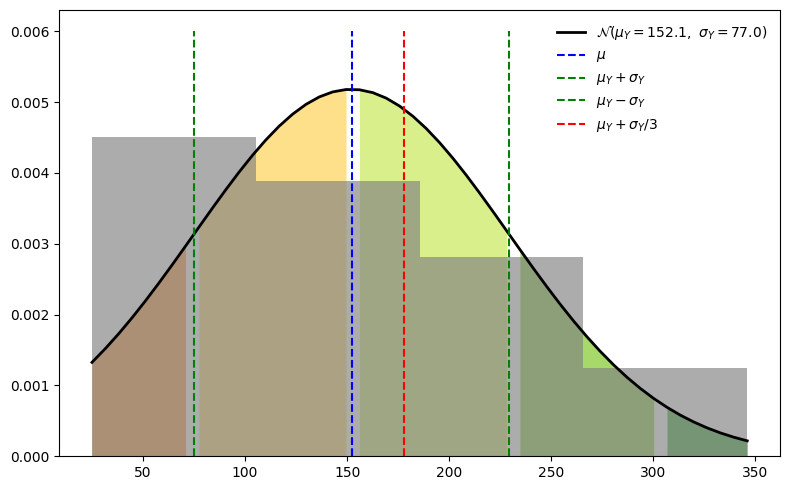

In [335]:
x = np.linspace(min(diabetes_Y), max(diabetes_Y))
diabetes_Y_pdf = sp.stats.norm.pdf(x,loc=mu_Y,scale=sigma_Y)
fig, ax = plt.subplots(figsize = (8, 5))
#ax.hist(diabetes_Y, density=True, bins='auto',histtype='bar',alpha=0.65,color='gray',cumulative=True)
#ax.plot([[25],[350]], [[0.5],[0.5]], '--k',label = '50%' )

ax.plot(x, diabetes_Y_pdf, lw = 2, color = 'k',  label = r'$\mathcal{N}\left( \mu_Y = %.1f,\  \sigma_Y = %.1f \right)$'%(mu_Y, sigma_Y))
ax.plot([[mu_Y],[mu_Y]],[[0],[0.006]], '--b', label = '$\mu$' )
ax.plot([[mu_Y+sigma_Y],[mu_Y+sigma_Y]],[[0],[0.006]], '--g',label = '$\mu_Y+\sigma_Y$' )
ax.plot([[mu_Y-sigma_Y],[mu_Y-sigma_Y]], [[0],[0.006]], '--g',label = '$\mu_Y-\sigma_Y$' )
ax.plot([[mu_Y+sigma_Y/3],[mu_Y+sigma_Y/3]],[[0],[0.006]], '--r',label = '$\mu_Y+\sigma_Y/3$' )

ax.legend(loc='best', frameon=False)

#brewer map qualitative colors
colors = ['#d73027','#f46d43','#fdae61','#fee08b','#d9ef8b','#a6d96a','#66bd63','#1a9850']
for i, color in zip(range(-4, 4), colors):
    low = mu_Y + i * sigma_Y
    high = mu_Y + (i + 1) * sigma_Y
    matches=np.where(np.logical_and(x >= low, x <= high))
    plt.fill_between(
        x[matches],
        diabetes_Y_pdf[matches],
        color=color,
        #alpha=0.85,
        linewidth=0,
    )
    
ax.hist(diabetes_Y, density=True, bins=4,histtype='barstacked',alpha=0.65,color='gray')
plt.tight_layout()    
plt.show()

We observe that the output distribution is noncentric, as the data is biased towards $\mu_Y-\sigma_Y$, proving wrong the *normally-distributed-output* assumption. By varying the amount of bins in the histogram we infeer that a higher number of qualitative labels may be needed. To simplify the problem we propose a 4 bins histogram, such that each _quantile_ is matched with the proposed label set $\mathcal{A}$. 

Although this labeling defines a _multiclass classification_, one can always partition the space using the mean value $\mu_Y$ as threshold  and getting a binary label set $\mathcal{A}_{\text{bin}} := \left\lbrace \text{Poor}= \left\lbrace \text{Low}, \text{Moderate} \right\rbrace, \text{Good}=\left\lbrace \text{High}, \text{Outstanding} \right\rbrace\right\rbrace$.

[//]: # "However, as we're _young and res(t)/(k)less_, we'll try to perform a multiclass classification. We shall began by finding the quantiles for the feature class"


In [336]:
#quantiles_mapping = np.percentile(diabetes_Y, np.linspace(0,100,5))
#quantiles_mapping

Finally, we define the decision threshold as follows: 


In [337]:
positive_progress_threshold = mu_Y  + sigma_Y/3#mu_Y#

hence, we choose the binary label set $\mathcal{A}_{\text{bin}}=\left\lbrace \text{\verb+bad+}, \text{\verb+good+}\right\rbrace$ numerically evaluated as $-1$ for the $\verb+bad+$ progession score, and $+1$ for the  $\verb+bad+$ progession score. Finally the dataset output labes are assigned follows:

In [338]:

diabetes_Y_labels = (-1)*np.not_equal(diabetes_Y >= positive_progress_threshold, True)+(diabetes_Y >= positive_progress_threshold)  
#diabetes_Y_labels = np.sign(diabetes_Y-positive_progress_threshold)
np.unique(diabetes_Y_labels) # guarantee the binary classification label set

array([-1,  1])

### Summary: 

  - The dataset $\bm{X}:=$`diabetes_x` is composed of $n:=$`442` normalized and centered samples.
  - Each  $\bm{x}^{(i)}\bm{X}$ is represented as a 10-dimensional ($d=10$) vector $\bm{x}^{(i)}\in\Reals^{10}.$
  - The input dataset $\bm{X}\subset\Reals{n\times d}$ has an `np.vstack`-ed form
    \begin{equation*} 
    \displaystyle
      \verb+diabetes_x+\equiv\bm{X}= 
        \begin{pmatrix} 
          x^{(1)}_1   & x^{(1)}_2   & \cdots & x^{(1)}_{d-1}   & x^{(1)}_d   \\
          x^{(2)}_1   & x^{(2)}_2   & \cdots & x^{(2)}_{d-1}   & x^{(2)}_d   \\ 
          \vdots      & \vdots      & \vdots & \vdots          & \vdots      \\
          x^{(n-1)}_1 & x^{(n-1)}_2 & \cdots & x^{(n-1)}_{d-1} & x^{(n-1)}_d \\ 
          x^{(n)}_1   & x^{(n)}_2   & \cdots & x^{(n)}_{d-1}   & x^{(n)}_d 
        \end{pmatrix} 
        =
        \begin{pmatrix}
          {\bm{x}^{(1)}}^{\intercal}   \\ 
          {\bm{x}^{(2)}}^{\intercal}   \\ 
          \vdots                       \\
          {\bm{x}^{(n-1)}}^{\intercal} \\ 
          {\bm{x}^{(n)}}^{\intercal}
        \end{pmatrix}
    \end{equation*}
  hence, it's straight forward to extend the input space $\tilde{\bm{X}}=\left(\bm{e}_{n\times 1}, \bm{X}\right)$, where $\Reals^{n}\ni \bm{e}_{n\times 1}:=\left(1, \cdots, 1\right)$ .
  -  The output/feature space is labeled using the mean $\mu_Y$ as the decision threshold, `positive_progress_threshold`, defining a binary classification problem. 

### 2.2 Extending the input dataset

----

In [339]:
extra_dimension = np.ones([n_samples,1])
X_tilde = np.hstack([extra_dimension, diabetes_X])
X_tilde.shape

(442, 11)

## 3. Building the linear classificator

---


As suggested in the assignment statement, we firstly need to partition our input data into training and testing sets, for that purpose we'll be using the  `train_test_split(X,Y, train_size)` from the  `sklearn.model_selection` library, choosing 20% of the samples for training.

![](image.png)

*Figure 1. Supervised Training Process. Recovered from the course notes.*

In [340]:
diabetes_X_train, diabetes_X_test, diabetes_Y_train, diabetes_Y_test = train_test_split(X_tilde, diabetes_Y_labels, train_size=0.2)

Now, we can implement the class linear classificator. We begin by obtaining the the so-called extended _covariant matrix_ $C = \tilde{\bm{X}}^\intercal \tilde{\bm{X}}$

In [341]:
CovX = np.matmul(diabetes_X_train.T, diabetes_X_train)
np.linalg.matrix_rank(CovX)

11

Then the we compute the linear regressor weights as $\tilde{\bm{w}}=C^{-1}\tilde{X}^{\intercal}\tilde{Y}$ 

In [342]:
W = np.matmul( np.linalg.inv(CovX) , np.matmul(diabetes_X_train.T,diabetes_Y_train) )
W

array([[ -0.27812184],
       [ -1.61530582],
       [  1.2162778 ],
       [  3.41434781],
       [  4.2636922 ],
       [-13.06935469],
       [ 11.03334676],
       [  2.86270178],
       [  0.39873288],
       [ 11.39531931],
       [ -0.34989758]])

In [343]:
W.shape

(11, 1)

having estimated the classificator weights we procced to make predictions for the test data

In [344]:
estimated_test_values = np.matmul(diabetes_X_test, W)

and then assign the appropiate clasas label

In [345]:
predicted_test_labels = np.sign(estimated_test_values)
np.unique(predicted_test_labels)


array([-1.,  1.])

choosing a binary loss function, we can compute the prediction error 

In [346]:
prediction_error = abs(predicted_test_labels- diabetes_Y_test)/2
prediction_error


array([[1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],

finally, the cost function arise as

In [347]:
squared_performance_error = np.dot(prediction_error.T,prediction_error)/(diabetes_X_test.shape[0])
squared_performance_error

array([[0.23446328]])

yielding `25.142%` of classification error for the training set.

Furthermore, we can measure the accuracy by counting the correct guesses for the training set.

In [348]:
class_linear_classificator_accuracy = sum( predicted_test_labels == diabetes_Y_test )/(diabetes_X_test.shape[0])
class_linear_classificator_accuracy

array([0.76553672])

### 4. Sklearn Linear Regressor

---

In order to label our training dataset, let us plot the feature dataset scattering

In [349]:
# Create a linear regression
regr = linear_model.LinearRegression(fit_intercept=False,copy_X=False)

We first notice that the `LinearRegression` expects the data to be centered, meanwhile this is true for the input data `diabetes_X`, from Section 2.1 we notice that data is centered w.r.t $\mu_Y$, hence one may consider to _complete the vector space_ using `fit_intercept=True`, or simply define `Y=diabetes_Y - \mu_y`. However, to be able to compare our linear classificators performance, we'll use the _noncentric_ training dataset `(diabetes_X_train, diabetes_Y_train)`.

We procced to train the _linear regression **model**_ using the training set

In [350]:
regr.fit(diabetes_X_train, diabetes_Y_train)

LinearRegression(copy_X=False, fit_intercept=False)

Let us take a look to the estimated coefficients for both classificators:

In [351]:
np.hstack([regr.coef_.T, W])

array([[ -0.27812184,  -0.27812184],
       [ -1.61530582,  -1.61530582],
       [  1.2162778 ,   1.2162778 ],
       [  3.41434781,   3.41434781],
       [  4.2636922 ,   4.2636922 ],
       [-13.06935469, -13.06935469],
       [ 11.03334676,  11.03334676],
       [  2.86270178,   2.86270178],
       [  0.39873288,   0.39873288],
       [ 11.39531931,  11.39531931],
       [ -0.34989758,  -0.34989758]])

they're apperently identical, yet a closer look reveals

In [352]:
np.hstack([np.equal(regr.coef_.T, W), regr.coef_.T- W])

array([[ 0.00000000e+00,  2.94209102e-14],
       [ 0.00000000e+00, -7.77156117e-15],
       [ 0.00000000e+00,  1.08801856e-14],
       [ 0.00000000e+00, -1.46549439e-14],
       [ 0.00000000e+00,  8.88178420e-16],
       [ 0.00000000e+00, -1.08357767e-13],
       [ 0.00000000e+00,  2.06057393e-13],
       [ 0.00000000e+00, -1.50990331e-14],
       [ 0.00000000e+00, -3.49165141e-14],
       [ 0.00000000e+00,  7.81597009e-14],
       [ 0.00000000e+00,  2.66453526e-15]])

that the difference is meerly a numerical precision error, concluding that the obtained weigths, in practice, are identical. To prove it let us make a prediction for the test set

In [353]:
# Make predictions using the testing
diabetes_Y_pred_sk = regr.predict(diabetes_X_test)
diabetes_Y_pred_sk

array([[-9.60439727e-02],
       [-6.86952699e-01],
       [ 4.64404144e-01],
       [ 5.51458119e-01],
       [-1.60759254e-01],
       [-5.33436369e-04],
       [ 2.27572150e-01],
       [-4.66289710e-01],
       [ 2.95306012e-01],
       [ 7.93693542e-01],
       [-9.79891289e-01],
       [-1.08031059e+00],
       [-4.05370635e-01],
       [ 1.31632849e-01],
       [-6.37239036e-01],
       [ 7.76419366e-02],
       [-7.69912096e-01],
       [ 1.23186169e-01],
       [-3.97761183e-01],
       [-1.05186181e+00],
       [ 4.34342432e-01],
       [-1.12252042e+00],
       [-6.43187723e-01],
       [ 9.48475212e-02],
       [ 3.71316966e-03],
       [-3.36749783e-01],
       [-8.95938060e-01],
       [ 1.10447468e-01],
       [ 2.52565031e-01],
       [-9.35565750e-01],
       [-1.30893202e+00],
       [-1.97281261e-01],
       [-4.76594888e-02],
       [-3.95347504e-01],
       [ 3.54829818e-01],
       [-2.50954759e-01],
       [-3.40379799e-01],
       [-7.05742018e-01],
       [-3.5

In [354]:
diabetes_Y_pred_label_sk = np.sign(diabetes_Y_pred_sk)
np.unique(diabetes_Y_pred_label_sk)


array([-1.,  1.])

Finally we can evaluate the prediction accuracy just as the previous section

In [355]:
prediction_error_sk = abs(diabetes_Y_pred_label_sk- diabetes_Y_test)/2
prediction_error_sk
squared_performance_error_sk = np.dot(prediction_error_sk.T,prediction_error_sk)/(diabetes_X_test.shape[0])
squared_performance_error_sk

array([[0.23446328]])

In [356]:
sklearn_linear_classificator_accuracy = sum( diabetes_Y_pred_label_sk == diabetes_Y_test )/(diabetes_X_test.shape[0])
sklearn_linear_classificator_accuracy
#sum(diabetes_label_prediction_error != 0)

array([0.76553672])

And then compare the performance using the accuracy metric

In [357]:
classificators_accuracy = np.array([class_linear_classificator_accuracy, sklearn_linear_classificator_accuracy])
np.argmax(class_linear_classificator_accuracy)

0

but 

In [358]:
sklearn_linear_classificator_accuracy == class_linear_classificator_accuracy


array([ True])

Therefore we conclude that _**both models have the same accuracy**_. 

### 5. Discussions
----

Despite finding equal performance for both models, we shall return to the discussion proposed in section 2.1, particullary to the histogram shown in Figure 2. indicating that the _quantitative measure of disease progression_ (`diabetes_Y`) has a noncentric distribution, suggesting that i) output data may be centered, and ii) the classification may require an extended label set $\mathcal{A}$.
![](output.png)

*Figure 2. Output data histogram and fitted normal distribution.*   

The first observation can be easiliy verified by setting `regr = linear_model.LinearRegression(fit_intercept=True,copy_X=False)` in line 83, yielding to the exact same conclusion and one minor difference: $w_0=0$ for the `sklearn` linear regressor. Such behavior is to be expected as data is centered w.r.t the mean, hence the _hyperplane_ $\tilde{\bm{w}}^\intercal\bm{x} = 0$ is centered in the origin.

In the other hand, the performance can be improved by setting the so-called _"decision  threshold"_ as $\mu +\sigma_3$, however, the result doesn't get better than `80%` of accuracy.

However, this result is not conclusive about the suitability of linear classificators to assest progression predictions for the dataset, despite of the model (class vs sklearn), instead, there arises the need for a systematic approach to determine the separation bundary, i.e. improve the "_qualitative progression measure_".
